<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/01_GNN_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks for Molecular Representation: Tutorial

## Table of Contents
1. [Setup and Installation](#setup-and-installation)
2. [Introduction](#introduction)
3. [Theoretical Background: Molecules as Graphs](#theoretical-background-molecules-as-graphs)
4. [Implementing Molecular Graph Representations](#implementing-molecular-graph-representations)
5. [PyTorch Geometric for Molecular Graphs](#pytorch-geometric-for-molecular-graphs)
6. [Working with Molecular Datasets](#working-with-molecular-datasets)
7. [Visualizing Molecular Graphs](#visualizing-molecular-graphs)
8. [Conclusion](#conclusion)

## 1. Setup and Installation <a name="setup-and-installation"></a>

First, we'll install and import the required libraries. We'll need:
- **RDKit**: For molecular manipulation and cheminformatics
- **PyTorch Geometric**: For graph neural network implementations
- **Matplotlib & Seaborn**: For visualization
- **NetworkX**: For graph manipulation and visualization

In [1]:
#@title install required libraries
!pip install -q rdkit
!pip install -q torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.1 MB/s eta 0:00:00


Now let's import the libraries we'll need throughout this tutorial:


In [1]:
#@title Import required libraries
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# RDKit for molecular handling
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

# PyTorch and PyTorch Geometric
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import to_networkx

# NetworkX for graph visualization
import networkx as nx

# Set plotting style
sns.set_context("notebook", font_scale=1.5)
sns.set_palette("Set2")

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 2. Introduction <a name="introduction"></a>

Historically, the biggest difficulty for machine learning with molecules was the choice and computation of "descriptors". Graph neural networks (GNNs) are a category of deep neural networks whose inputs are graphs and provide a way around the choice of descriptors. A GNN can take a molecule directly as input.

GNNs are specific layers that input a graph and output a graph. You can find reviews of GNNs in Dwivedi *et al.*{cite}`dwivedi2020benchmarking`, Bronstein *et al.*{cite}`bronstein2017geometric`, and  Wu *et al.*{cite}`wu2020comprehensive`. GNNs can be used for everything from coarse-grained molecular dynamics {cite}`li2020graph` to predicting NMR chemical shifts {cite}`yang2020predicting` to modeling dynamics of solids {cite}`xie2019graph`. Before we dive too deep into them, we must first understand how a graph is represented in a computer and how molecules are converted into graphs.

You can find an interactive introductory article on graphs and graph neural networks at [distill.pub](https://distill.pub/2021/gnn-intro/) {cite}`sanchez-lengeling2021a`. Most current research in GNNs is done with specialized deep learning libraries for graphs. The most common are [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), [Deep Graph library](https://www.dgl.ai/), [DIG](https://github.com/divelab/DIG), [Spektral](https://graphneural.network/), and [TensorFlow GNNS](https://github.com/tensorflow/gnn).

### Learning Objectives

By the end of this tutorial, you will be able to:
- **Understand** the theoretical foundations of graph representations for molecules
- **Implement** conversion from molecular structures to graph data structures
- **Distinguish** between graph, node, and edge features and their chemical significance
- **Work with** PyTorch Geometric for molecular graph manipulation
- **Visualize** molecular graphs and their learned representations

## 3. Theoretical Background: Molecules as Graphs <a name="theoretical-background-molecules-as-graphs"></a>


### What is a Graph?

A graph G is defined by a set of nodes (vertices) V and edges E. In the context of molecules:
- **Nodes** represent atoms
- **Edges** represent bonds between atoms

Mathematically, we can represent an attributed graph in several ways:
1. **Adjacency Matrix**: A matrix E where e_ij = 1 if nodes i and j are connected
2. **Node Feature Matrix**: A matrix V where each row represents the features of a node
3. **Edge Feature Matrix**: A tensor where each entry e_ij represents features of the connection between nodes i and j

### Representing Molecules as Graphs

Let's consider a simple molecule: methanol (CH₃OH).


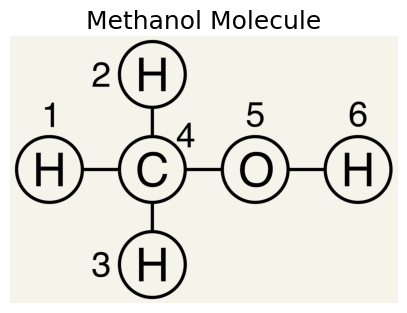

In [3]:
# Download methanol image for visualization
!wget -q https://github.com/whitead/dmol-book/blob/main/dl/methanol.jpg?raw=true -O methanol.jpg

# Display the molecule
from PIL import Image
img = Image.open('methanol.jpg')
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis('off')
plt.title('Methanol Molecule')
plt.show()

Let's see how a graph can be constructed from a molecule. Consider methanol, shown in the figure.

When representing methanol as a graph:
1. We have 6 nodes (atoms): 1 carbon (C), 1 oxygen (O), and 4 hydrogens (H)
2. We have 5 edges (bonds): 1 C-O, 1 O-H, and 3 C-H bonds


#### Node Features

For each atom (node), we need to define a feature vector. Commonly used atom features include:
- **Atom type** (usually one-hot encoded)
- **Formal charge**
- **Hybridization state**
- **Aromaticity**
- **Number of connected hydrogens**

For simplicity, let's start with just atom type using one-hot encoding:

In [2]:
# Define a simple mapping of atoms to indices
atom_mapping = {'H': 0, 'O': 1, 'C': 2}

# Let's visualize the node feature matrix for methanol
# Atom order:  H, H, H, C, O, H
node_features = np.zeros((6, 3))  # 6 atoms, 3 possible atom types
node_features[0, 0] = 1  # H
node_features[1, 0] = 1  # H
node_features[2, 0] = 1  # H
node_features[3, 2] = 1  # C
node_features[4, 1] = 1  # O
node_features[5, 0] = 1  # H

print("Node Feature Matrix (Rows: Atoms, Columns: Atom Types):")
node_df = pd.DataFrame(node_features,
                      index=['1', '2', '3', '4', '5', '6'],
                      columns=['H', 'O', 'C'])
display(node_df)

Node Feature Matrix (Rows: Atoms, Columns: Atom Types):


H    O    C
1  1.0  0.0  0.0
2  1.0  0.0  0.0
3  1.0  0.0  0.0
4  0.0  0.0  1.0
5  0.0  1.0  0.0
6  1.0  0.0  0.0

#### Adjacency Matrix

The adjacency matrix represents which atoms are bonded to each other:

In [3]:
# Let's create the adjacency matrix for methanol
# Atom order: H, H, H, C, O, H (indexed from 0 to 5)
adjacency = np.zeros((6, 6))

# Define bonds: C-O, O-H and C-H bonds
bonds = [(0, 3),  # C-H1
         (1, 3),  # C-H2
         (2, 3),  # C-H3
         (3, 4),  # C-O
         (4, 5)]  # O-H4

# Fill the adjacency matrix (undirected graph, so matrix is symmetric)
for i, j in bonds:
    adjacency[i, j] = 1
    adjacency[j, i] = 1  # Symmetric because bonds are undirected

print("Adjacency Matrix (1 indicates a bond between atoms):")
adj_df = pd.DataFrame(adjacency,
                      index=['1', '2', '3', '4', '5', '6'],
                      columns=['1', '2', '3', '4', '5', '6'])
display(adj_df)

Adjacency Matrix (1 indicates a bond between atoms):


1    2    3    4    5    6
1  0.0  0.0  0.0  1.0  0.0  0.0
2  0.0  0.0  0.0  1.0  0.0  0.0
3  0.0  0.0  0.0  1.0  0.0  0.0
4  1.0  1.0  1.0  0.0  1.0  0.0
5  0.0  0.0  0.0  1.0  0.0  1.0
6  0.0  0.0  0.0  0.0  1.0  0.0

#### Edge Features

We can also define features for each bond (edge), such as:
- **Bond type** (single, double, triple, aromatic)
- **Bond length**
- **Bond angle**

For simplicity, we'll just use bond type as a feature:

In [4]:
# Create an edge feature tensor for methanol
# We'll use one-hot encoding for bond types: [single, double, triple, aromatic]
num_bonds = len(bonds)
edge_features = np.zeros((num_bonds, 4))  # 5 bonds, 4 possible bond types

# All bonds in methanol are single bonds (index 0)
edge_features[:, 0] = 1

print("Edge Feature Matrix (Rows: Bonds, Columns: Bond Types):")
edge_df = pd.DataFrame(edge_features,
                      index=['C-H1', 'C-H2', 'C-H3', 'C-O', 'O-H4'],
                      columns=['Single', 'Double', 'Triple', 'Aromatic'])
display(edge_df)

Edge Feature Matrix (Rows: Bonds, Columns: Bond Types):


Single  Double  Triple  Aromatic
C-H1     1.0     0.0     0.0       0.0
C-H2     1.0     0.0     0.0       0.0
C-H3     1.0     0.0     0.0       0.0
C-O      1.0     0.0     0.0       0.0
O-H4     1.0     0.0     0.0       0.0

### Visualizing the Graph Representation

Let's visualize the methanol molecule as a graph:

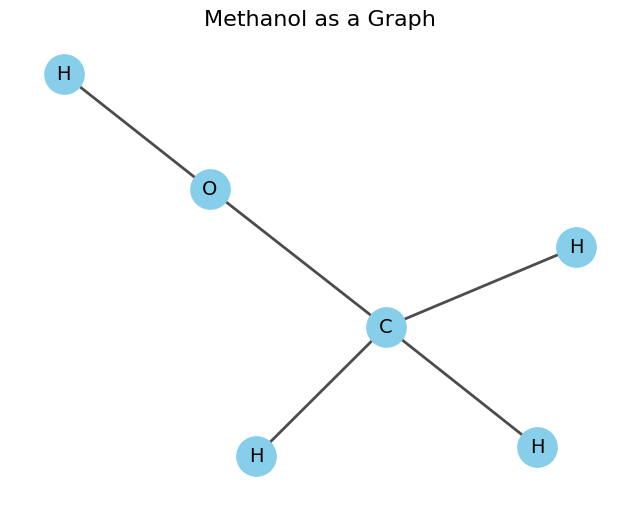

In [5]:
def visualize_molecular_graph(adjacency, node_labels):
    """Visualize a molecule as a graph.
    
    Args:
        adjacency (numpy.ndarray): Adjacency matrix representing molecular bonds
        node_labels (list): List of atom labels (e.g., ['H', 'C', 'O'])
    """
    # Initialize an empty NetworkX graph
    G = nx.Graph()

    # Add nodes to the graph with their corresponding atom labels
    # Each node represents an atom in the molecule
    for i, label in enumerate(node_labels):
        G.add_node(i, label=label)

    # Extract edges from the adjacency matrix
    # np.where returns indices where adjacency == 1 (indicating a bond)
    rows, cols = np.where(adjacency == 1)
    edges = zip(rows.tolist(), cols.tolist())
    
    # Add edges to the graph
    # Only add each edge once (i < j) since it's an undirected graph
    for i, j in edges:
        if i < j:  # Add each edge only once
            G.add_edge(i, j)

    # Create a new figure for plotting
    plt.figure(figsize=(8, 6))
    
    # Calculate node positions using spring layout algorithm
    # seed=42 ensures reproducible layout
    pos = nx.spring_layout(G, seed=42)

    # Draw the nodes as blue circles
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
    
    # Add atom labels to each node
    nx.draw_networkx_labels(G, pos, 
                           labels={i: node_labels[i] for i in range(len(node_labels))}, 
                           font_size=14)

    # Draw the edges (bonds) between nodes
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.7)

    # Remove axis for cleaner visualization
    plt.axis('off')
    plt.title('Methanol as a Graph', fontsize=16)
    plt.show()

# Define atom labels for methanol molecule (CH3OH)
# Order: 3 hydrogens attached to carbon, carbon, oxygen, hydrogen attached to oxygen
atom_labels = ['H', 'H', 'H', 'C', 'O', 'H']

# Create visualization using the adjacency matrix and atom labels
visualize_molecular_graph(adjacency, atom_labels)

### From Chemical Structure to Graph: The Complete Picture

Now let's put it all together to understand the flow from a chemical structure to a graph representation:

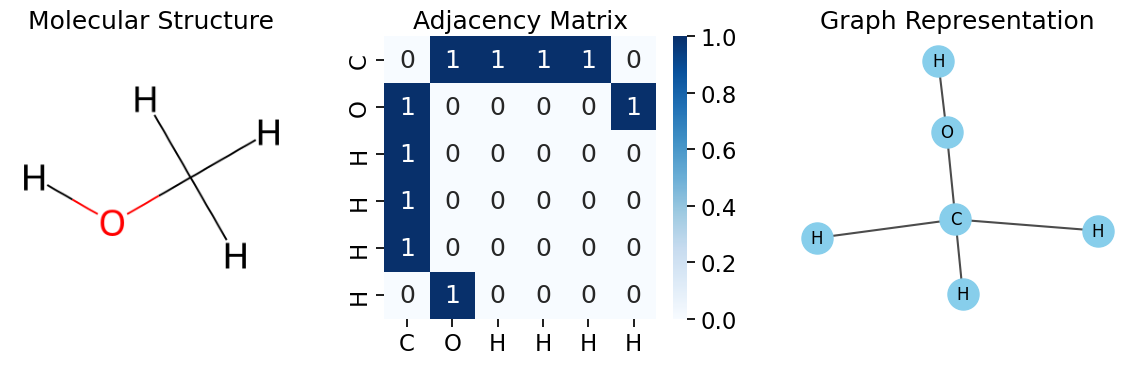

In [6]:
def show_molecule_to_graph_conversion(smiles: str):
    """
    Show the conversion from molecular structure to graph representation.
    
    This function takes a SMILES string and creates three visualizations:
    1. The molecular structure (from rdkit)
    2. The adjacency matrix showing atom connections
    3. The graph representation of the molecule
    
    Args:
        smiles (str): SMILES string representing the molecule
        
    Returns:
        tuple: (mol, adj_matrix, node_features, atoms)
            - mol: RDKit molecule object
            - adj_matrix: Adjacency matrix showing atom connections
            - node_features: One-hot encoded features for each atom
            - atoms: List of atom symbols in the molecule
    """
    # Step 1: Create RDKit molecule and add hydrogens
    mol = Chem.MolFromSmiles(smiles)  # Convert SMILES to RDKit molecule
    mol = Chem.AddHs(mol)  # Add hydrogens to get complete structure

    # Step 2: Create figure with three subplots
    plt.figure(figsize=(12, 4))
    
    # Step 3: Draw molecular structure (left subplot)
    plt.subplot(1, 3, 1)
    img = Draw.MolToImage(mol, size=(300, 300))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Molecular Structure')

    # Step 4: Extract atom information
    atoms = [a.GetSymbol() for a in mol.GetAtoms()]  # Get atom symbols

    # Step 5: Create adjacency matrix
    n_atoms = len(atoms)
    adj_matrix = np.zeros((n_atoms, n_atoms))  # Initialize with zeros

    # Fill adjacency matrix based on bonds
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()  # Get start atom index
        j = bond.GetEndAtomIdx()    # Get end atom index
        adj_matrix[i, j] = 1        # Mark connection in both directions
        adj_matrix[j, i] = 1        # (since bonds are undirected)

    # Step 6: Create node features using one-hot encoding
    unique_atoms = sorted(set(atoms))  # Get unique atom types
    atom_to_idx = {atom: i for i, atom in enumerate(unique_atoms)}  # Map atoms to indices

    # Initialize node features matrix
    node_features = np.zeros((n_atoms, len(unique_atoms)))
    # Fill node features matrix
    for i, atom in enumerate(atoms):
        node_features[i, atom_to_idx[atom]] = 1  # Set 1 for corresponding atom type

    # Step 7: Visualize adjacency matrix (middle subplot)
    plt.subplot(1, 3, 2)
    sns.heatmap(adj_matrix, cmap='Blues', annot=True, fmt='.0f',
                xticklabels=atoms, yticklabels=atoms)
    plt.title('Adjacency Matrix')

    # Step 8: Create and visualize graph (right subplot)
    plt.subplot(1, 3, 3)
    G = nx.Graph()  # Create empty graph

    # Add nodes with atom labels
    for i, atom in enumerate(atoms):
        G.add_node(i, label=atom)

    # Add edges based on adjacency matrix
    rows, cols = np.where(adj_matrix == 1)  # Get indices of connections
    edges = zip(rows.tolist(), cols.tolist())
    for i, j in edges:
        if i < j:  # Add each edge only once (avoid duplicates)
            G.add_edge(i, j)

    # Plot the graph with custom styling
    pos = nx.spring_layout(G, seed=42)  # Calculate node positions
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)  # Draw nodes
    nx.draw_networkx_labels(G, pos, labels={i: atoms[i] for i in range(len(atoms))}, 
                           font_size=12)  # Add atom labels
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)  # Draw edges
    plt.axis('off')
    plt.title('Graph Representation')

    # Finalize plot
    plt.tight_layout()
    plt.show()

    return mol, adj_matrix, node_features, atoms

# Demonstrate the function with methanol (CH3OH)
methanol_smiles = "CO"
mol, adj_matrix, node_features, atoms = show_molecule_to_graph_conversion(methanol_smiles)

### ✅ Checkpoint: Understanding Molecular Graphs

To reinforce your understanding, try answering these questions:

1. **Question**: What does each row in the node feature matrix represent?
   - **Answer**: Each row represents one atom in the molecule, with its features encoded.

2. **Question**: Why is the adjacency matrix symmetric for molecules?
   - **Answer**: Because chemical bonds are undirected (atoms are mutually bonded to each other).

3. **Question**: How would the graph representation change for a molecule with a double bond?
   - **Answer**: The edge feature for that bond would have a 1 in the position representing double bonds instead of single bonds.

## 4. Implementing Molecular Graph Representations <a name="implementing-molecular-graph-representations"></a>

Now, let's create a function to convert any molecule (represented as a SMILES string) into a graph representation:
1. **Identifying nodes**: Each atom becomes a node in our graph
2. **Creating node features**: We'll encode atom properties (element type, charge, etc.)
3. **Identifying edges**: Each chemical bond becomes an edge in our graph
4. **Creating edge features**: We'll encode bond properties (single, double, aromatic, etc.)

This conversion allows us to represent any molecular structure as a set of matrices that capture both the topology (connectivity) and the chemical properties of the molecule.

The function below performs this conversion:

In [7]:
def smiles_to_graph(smiles: str):
    """
    Convert a SMILES string to graph representation.

    Args:
        smiles (str): SMILES string of the molecule (e.g., "CCO" for ethanol)

    Returns:
        tuple:
            - node_features: Matrix where each row represents an atom's properties
            - adjacency: Matrix showing which atoms are connected by bonds
            - edge_features: Matrix containing properties of each bond
            - edge_indices: List of atom pairs connected by bonds
    """
    # Step 1: Parse the SMILES string using RDKit
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    # Step 2: Add hydrogen atoms explicitly
    # In SMILES, hydrogens are often implicit but we need them for complete graphs in this tutorial
    mol = Chem.AddHs(mol)

    # Step 3: Define bond type mapping (translates chemical bond types to indices)
    # This mapping helps us create one-hot encodings for different bond types
    bond_type_to_idx = {
        Chem.rdchem.BondType.SINGLE: 0,
        Chem.rdchem.BondType.DOUBLE: 1,
        Chem.rdchem.BondType.TRIPLE: 2,
        Chem.rdchem.BondType.AROMATIC: 3,
    }

    # Step 4: Count the total number of atoms in the molecule
    n_atoms = mol.GetNumAtoms()

    # Step 5: Create node features matrix
    # We're using one-hot encoding for atom types (C, O, N, H, and "other")
    elements = ["C", "O", "N", "H", "Other"]
    node_features = np.zeros((n_atoms, len(elements)))

    # Step 6: Fill node features matrix with atom information
    for atom in mol.GetAtoms():
        idx = atom.GetIdx() # Get atom's position in the molecule
        symbol = atom.GetSymbol() # Get atom's chemical symbol

        # Convert atom element to one-hot encoding
        if symbol in elements:
            node_features[idx, elements.index(symbol)] = 1 # One-hot encode atom type
        else:
            # Mark as "other" if not in our element list
            node_features[idx, -1] = 1

    # Step 7: Initialize adjacency matrix and edge feature storage
    # Adjacency matrix shows which atoms are connected
    adjacency = np.zeros((n_atoms, n_atoms))
    edge_features = [] # Will store properties of each bond
    edge_indices = [] # Will store which atoms are connected

    # Step 8: Process each bond in the molecule
    for bond in mol.GetBonds():
        # Get the atoms connected by this bond
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()

        # Update adjacency matrix to show these atoms are connected
        # Both entries are 1 because chemical bonds are bidirectional (undirected graph)
        adjacency[begin_idx, end_idx] = 1
        adjacency[end_idx, begin_idx] = 1

        # Get bond type
        bond_type = bond.GetBondType()
        bond_feature = np.zeros(len(bond_type_to_idx))

        if bond_type in bond_type_to_idx:
            bond_feature[bond_type_to_idx[bond_type]] = 1
        else:
            print(f"Warning: Unknown bond type {bond_type}")

        # Add edge in both directions (undirected graph)
        edge_features.append(bond_feature)
        edge_indices.append((begin_idx, end_idx))

        edge_features.append(bond_feature)  # Same feature for the reverse direction
        edge_indices.append((end_idx, begin_idx))

    # Step 9: Convert edge features to numpy array for consistency
    if edge_features:
        edge_features = np.array(edge_features)
    else:
        edge_features = np.empty((0, len(bond_type_to_idx)))

    return node_features, adjacency, edge_features, edge_indices

# Let's test our function on several molecules
molecules = {
    "Methanol": "CO",
    "Ethanol": "CCO",
    "Benzene": "c1ccccc1",
    "Caffeine": "CN1C=NC2=C1C(=O)N(C)C(=O)N2C",
    "Aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O"
}

# Test with sample molecule (choose from Methanol, Ethanol, Benzene, Caffeine, and Aspirin)
sample_molecule="Methanol"
sample_features, sample_adj, sample_edge_features, sample_edge_indices = smiles_to_graph(molecules[sample_molecule])

print(f"{sample_molecule} Node Features:")
print(sample_features)
print(f" \n{sample_molecule} Adjacency Matrix:")
print(sample_adj)
print(f"\n{sample_molecule} Edge Features:")
print(sample_edge_features)

Methanol Node Features:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
 
Methanol Adjacency Matrix:
[[0. 1. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]

Methanol Edge Features:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Let's interpret what these matrices mean for methanol (CH₃OH):

**Node Features Matrix:**
- Each row represents one atom in the molecule
- The columns represent [C, O, N, H, Other]
- For example, row 3 has a 1 in the 4th position, indicating this is a hydrogen atom
- Row 1 has a 1 in the 1st position, indicating this is a carbon atom

**Adjacency Matrix:**
- This 6×6 matrix shows which atoms are bonded to each other
- Reading row 1 (carbon), we see 1s in positions 2, 3, 4, and 5, meaning the carbon is bonded to 3 hydrogen atoms and 1 oxygen atom
- This perfectly matches methanol's structure (CH₃OH)

**Edge Features:**
- Each row represents a bond in the molecule
- The columns represent [single, double, triple, aromatic]
- All rows have a 1 in the first position, indicating all bonds in methanol are single bonds

This representation captures both the structural connectivity and the chemical properties of methanol in a format that machine learning algorithms can process.

Let's analyze a more complex molecule to see the differences:

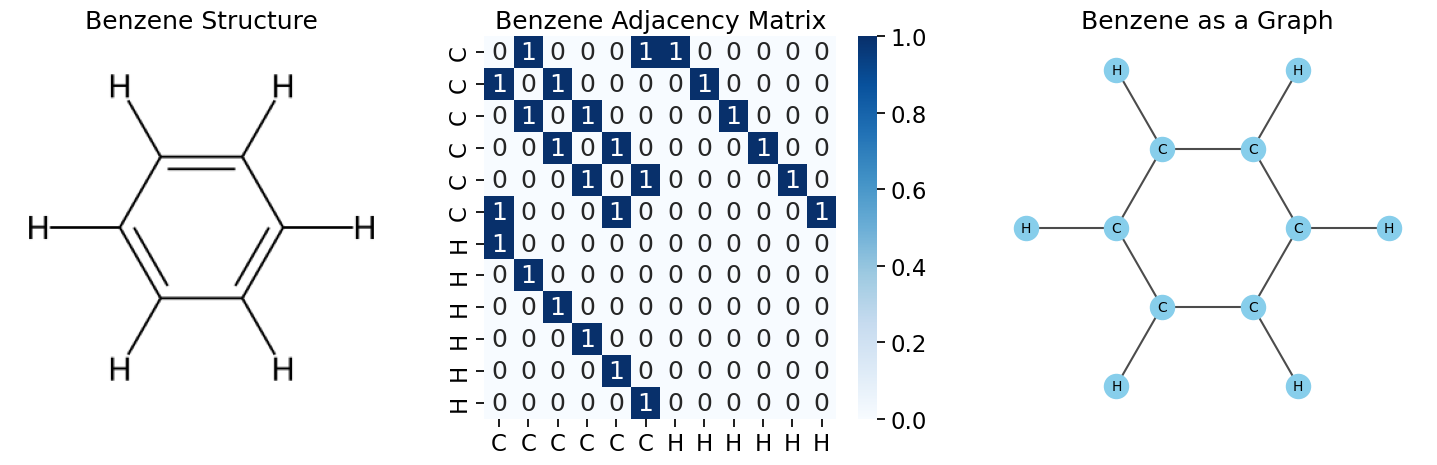

Benzene Edge Features (showing only a few):
Edge (0, 1): Aromatic bond
Edge (1, 0): Aromatic bond
Edge (1, 2): Aromatic bond
Edge (2, 1): Aromatic bond
Edge (2, 3): Aromatic bond
Edge (3, 2): Aromatic bond


In [8]:
# Let's analyze benzene in more detail
# Convert SMILES string to graph representation
benzene_features, benzene_adj, benzene_edge_features, benzene_edge_indices = smiles_to_graph(molecules["Benzene"])

# Create and prepare benzene molecule for visualization
benzene_mol = Chem.MolFromSmiles(molecules["Benzene"])
benzene_mol = Chem.AddHs(benzene_mol)  # Add hydrogens explicitly
AllChem.Compute2DCoords(benzene_mol)  # Generate 2D coordinates
benzene_img = Draw.MolToImage(benzene_mol, size=(300, 300))

# Create figure with 3 subplots
plt.figure(figsize=(15, 5))

# Plot 1: Molecular structure visualization
plt.subplot(1, 3, 1)
plt.imshow(benzene_img)
plt.axis('off')
plt.title('Benzene Structure')

# Plot 2: Adjacency matrix heatmap
plt.subplot(1, 3, 2)
atom_symbols = [atom.GetSymbol() for atom in benzene_mol.GetAtoms()]
sns.heatmap(benzene_adj, cmap='Blues', annot=True, fmt='.0f',
            xticklabels=atom_symbols, yticklabels=atom_symbols)
plt.title('Benzene Adjacency Matrix')

# Plot 3: Graph representation
plt.subplot(1, 3, 3)
G = nx.Graph()

# Add nodes with atom labels
for i, symbol in enumerate(atom_symbols):
    G.add_node(i, label=symbol)

# Add edges based on adjacency matrix
rows, cols = np.where(benzene_adj == 1)
edges = zip(rows.tolist(), cols.tolist())
for i, j in edges:
    if i < j:  # Avoid duplicate edges
        G.add_edge(i, j)

# Get 2D coordinates for graph layout
pos = {}
for i, atom in enumerate(benzene_mol.GetAtoms()):
    pos[i] = benzene_mol.GetConformer().GetAtomPosition(i)
    pos[i] = (pos[i].x, pos[i].y)

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=300)
nx.draw_networkx_labels(G, pos, labels={i: atom_symbols[i] for i in range(len(atom_symbols))}, font_size=10)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)
plt.axis('off')
plt.title('Benzene as a Graph')

plt.tight_layout()
plt.show()


# Analyze bond types in benzene
# Print bond information for first 6 edges
print("Benzene Edge Features (showing only a few):")
for i, (edge, feature) in enumerate(zip(benzene_edge_indices[:6], benzene_edge_features[:6])):
    # Determine bond type based on feature vector
    bond_type = "Single" if feature[0] == 1 else "Double" if feature[1] == 1 else "Triple" if feature[2] == 1 else "Aromatic"
    print(f"Edge {edge}: {bond_type} bond")


### Feature Engineering for Molecular Graphs

The simple representation above uses only atom type and bond type, but real-world applications often need more sophisticated features. While the basic representation captures molecular structure, chemists know that many properties depend on more detailed atomic and bond attributes. For example:

- An atom's **hybridization** affects its geometry and reactivity
- **Aromaticity** drastically changes chemical behavior
- **Ring structures** influence molecular rigidity and reactivity

The enhanced function below incorporates these important chemical concepts into our graph representation:

In [10]:
def advanced_smiles_to_graph(smiles: str):
    """
    Convert a SMILES string to graph representation with advanced features.

    Args:
        smiles (str): SMILES string of the molecule

    Returns:
        tuple: Node features, adjacency matrix, edge features, edge indices
    """
    # Create RDKit molecule from SMILES string
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    # Add hydrogens to explicit representation for complete molecular structure
    mol = Chem.AddHs(mol)

    # Define mapping of bond types to indices for one-hot encoding
    bond_type_to_idx = {
        Chem.rdchem.BondType.SINGLE: 0,
        Chem.rdchem.BondType.DOUBLE: 1,
        Chem.rdchem.BondType.TRIPLE: 2,
        Chem.rdchem.BondType.AROMATIC: 3,
    }

    # Get total number of atoms in the molecule
    n_atoms = mol.GetNumAtoms()

    # Initialize list to store node (atom) features
    node_features = []
    for atom in mol.GetAtoms():
        # Extract basic atomic properties
        atom_type = atom.GetSymbol()
        atomic_num = atom.GetAtomicNum()
        formal_charge = atom.GetFormalCharge()
        hybridization = atom.GetHybridization()
        is_aromatic = int(atom.GetIsAromatic())
        is_in_ring = int(atom.IsInRing())

        # Create one-hot encoding for common atom types
        # Includes C, O, N, H, F, P, S, Cl, Br, I, and an "Other" category (11 features)
        atom_types = ['C', 'O', 'N', 'H', 'F', 'P', 'S', 'Cl', 'Br', 'I']
        atom_type_onehot = [1 if atom_type == t else 0 for t in atom_types]
        if atom_type not in atom_types:
            atom_type_onehot.append(1)  # "Other" category
        else:
            atom_type_onehot.append(0)

        # Create one-hot encoding for hybridization states
        # Includes SP, SP2, SP3, and an "Other" category (4 features)
        hybridization_types = [
            Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3
        ]
        hybridization_onehot = [1 if hybridization == h else 0 for h in hybridization_types]
        if hybridization not in hybridization_types:
            hybridization_onehot.append(1)  # "Other" hybridization
        else:
            hybridization_onehot.append(0)

        # Combine all atomic features into a single feature vector
        features = atom_type_onehot + [
            formal_charge,            # Formal charge of the atom
            is_aromatic,             # Whether atom is part of an aromatic system
            is_in_ring,              # Whether atom is part of a ring
            atom.GetDegree(),        # Number of directly bonded neighbors
            atom.GetTotalNumHs(),    # Total number of hydrogens (explicit and implicit)
            atom.GetNumRadicalElectrons()  # Number of unpaired electrons
        ] + hybridization_onehot

        node_features.append(features)

    # Convert node features to numpy array for efficient computation
    node_features = np.array(node_features)

    # Initialize data structures for edge information
    adjacency = np.zeros((n_atoms, n_atoms))  # Adjacency matrix
    edge_features = []                        # List to store bond features
    edge_indices = []                         # List to store bond connections

    # Process each bond in the molecule
    for bond in mol.GetBonds():
        # Get indices of atoms involved in the bond
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()

        # Update adjacency matrix (symmetric for undirected graph)
        adjacency[begin_idx, end_idx] = 1
        adjacency[end_idx, begin_idx] = 1

        # Create one-hot encoding for bond type
        bond_type = bond.GetBondType()
        bond_type_onehot = np.zeros(len(bond_type_to_idx))
        if bond_type in bond_type_to_idx:
            bond_type_onehot[bond_type_to_idx[bond_type]] = 1

        # Extract additional bond properties
        is_conjugated = int(bond.GetIsConjugated())  # Whether bond is part of a conjugated system
        is_in_ring = int(bond.IsInRing())           # Whether bond is part of a ring

        # Combine all bond features
        features = np.concatenate([bond_type_onehot, [is_conjugated, is_in_ring]])

        # Add edge in both directions (undirected graph representation)
        edge_features.append(features)
        edge_indices.append((begin_idx, end_idx))

        edge_features.append(features)  # Same feature for the reverse direction
        edge_indices.append((end_idx, begin_idx))

    # Convert edge features to numpy array, handling empty case
    if edge_features:
        edge_features = np.array(edge_features)
    else:
        edge_features = np.empty((0, len(bond_type_to_idx) + 2))  # +2 for conjugation and ring features

    return node_features, adjacency, edge_features, edge_indices

# Test the function with Aspirin molecule
sample_molecule = "Aspirin"
aspirin_features, aspirin_adj, aspirin_edge_features, aspirin_edge_indices = advanced_smiles_to_graph(molecules[sample_molecule])

# Print summary of the graph representation
print(f"{sample_molecule} has {aspirin_features.shape[0]} atoms with {aspirin_features.shape[1]} features per atom")
print(f"{sample_molecule} has {len(aspirin_edge_indices) // 2} bonds with {aspirin_edge_features.shape[1]} features per bond")

# Display features of the first atom for inspection
print("\nFeatures for the first atom:")
aspirin_mol = Chem.MolFromSmiles(molecules[sample_molecule])
aspirin_mol = Chem.AddHs(aspirin_mol)
first_atom = aspirin_mol.GetAtomWithIdx(0)
print(f"Atom type: {first_atom.GetSymbol()}")
print(f"Feature vector: {aspirin_features[0]}")

Aspirin has 21 atoms with 21 features per atom
Aspirin has 21 bonds with 6 features per bond

Features for the first atom:
Atom type: C
Feature vector: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 1 0]


### Interpreting Advanced Features for Aspirin

The advanced representation for aspirin includes much richer chemical information:

1. **Atom Features Now Include:**
   - Element type (C, O, etc.)
   - Formal charge (important for reaction sites)
   - Hybridization state (sp, sp², sp³)
   - Aromaticity (critical for the benzene ring in aspirin)
   - Ring membership
   - Atomic degree (number of bonds, related to steric hindrance)
   - Hydrogen count (important for H-bonding)

2. **Bond Features Now Include:**
   - Bond type (single, double, etc.)
   - Conjugation (important for electron delocalization)
   - Ring membership (bonds within rings behave differently)

For the first atom (carbon), we see its complete chemical signature encoded in the feature vector. This rich representation allows machine learning models to recognize important pharmacophores and chemical patterns that determine aspirin's properties.

### ✅ Checkpoint Exercise: Implement Graph Representation for Ethanol

Now it's your turn to apply what you've learned:

### Exercise: Molecular Graph Implementation
1. Create and visualize the graph representation for ethanol (CCO).
2. Compare the adjacency matrices of methanol and ethanol. What differences do you observe?
3. Implement graph representation for a molecule with a ring structure, such as cyclohexane (C1CCCCC1). How does the adjacency matrix change when there are cycles in the molecule?

## 5. PyTorch Geometric for Molecular Graphs <a name="pytorch-geometric-for-molecular-graphs"></a>

Now that we understand the fundamentals of graph representation for molecules, let's implement this using PyTorch Geometric (PyG), a library specifically designed for graph neural networks. While our basic graph representation works well, specialized libraries like PyTorch Geometric (PyG) offer optimized data structures for graph machine learning. There are two main differences to understand:

1. **Edge Representation:** Instead of using an adjacency matrix, PyG uses a more efficient "COO" (COOrdinate) format that only stores the non-zero entries.

2. **Tensor Format:** All data is stored in PyTorch tensors rather than NumPy arrays, allowing GPU acceleration.

### Creating a PyG Data Object

PyTorch Geometric represents a graph using the `Data` class with several key attributes:
- `x`: Node feature matrix
- `edge_index`: Graph connectivity in COO format
- `edge_attr`: Edge feature matrix
- `y`: Target values (for prediction tasks)

The function below converts our chemical graph into PyG's specialized format. Let's convert our molecular graph representation to a PyG Data object:



### How to create a graph in PyTorch Geometric

In [11]:
def smiles_to_pyg(smiles: str):
    """
    Convert a SMILES string to a PyTorch Geometric Data object.

    Args:
        smiles (str): SMILES string of the molecule

    Returns:
        torch_geometric.data.Data: PyG Data object
    """
    # Step 1: Get the graph representation using our advanced SMILES parser
    # This gives us node features, adjacency matrix, edge features and edge indices
    node_features, adjacency, edge_features, edge_indices = advanced_smiles_to_graph(smiles)

    # Step 2: Convert node features to PyTorch tensor
    # Node features represent atom properties like atomic number, charge, etc.
    x = torch.tensor(node_features, dtype=torch.float)

    # Step 3: Convert edge indices to PyTorch tensor in COO (Coordinate) format
    # PyG expects edge_index to be of shape [2, num_edges] where:
    # - First row contains source node indices
    # - Second row contains target node indices
    # .t() transposes the matrix and .contiguous() ensures memory layout is optimal
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    # Step 4: Convert edge features to PyTorch tensor
    # Edge features represent bond properties like bond type, aromaticity, etc.
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Step 5: Create PyG Data object combining all components
    # x: node features
    # edge_index: graph connectivity
    # edge_attr: edge features
    # smiles: original SMILES string (stored for reference)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles)

    return data

# Test the function with aspirin molecule
# This will help us verify the conversion works correctly
aspirin_pyg = smiles_to_pyg(molecules["Aspirin"])

# Print the PyG Data object and its component shapes
print("PyG Data Object for Aspirin:")
print(aspirin_pyg)
print("\nNode Features Shape:", aspirin_pyg.x.shape)  # Shape: [num_nodes, num_node_features]
print("Edge Index Shape:", aspirin_pyg.edge_index.shape)  # Shape: [2, num_edges]
print("Edge Features Shape:", aspirin_pyg.edge_attr.shape)  # Shape: [num_edges, num_edge_features]

PyG Data Object for Aspirin:
Data(x=[21, 21], edge_index=[2, 42], edge_attr=[42, 6], smiles='CC(=O)OC1=CC=CC=C1C(=O)O')

Node Features Shape: torch.Size([21, 21])
Edge Index Shape: torch.Size([2, 42])
Edge Features Shape: torch.Size([42, 6])


### Understanding PyG Data Format

Let's take a closer look at the PyG Data object structure, particularly the edge_index format which might be unfamiliar:

Methanol as a PyG Data object:
Data(x=[6, 21], edge_index=[2, 10], edge_attr=[10, 6], smiles='CO')

Edge Index Tensor:
[[0 1 0 2 0 3 0 4 1 5]
 [1 0 2 0 3 0 4 0 5 1]]


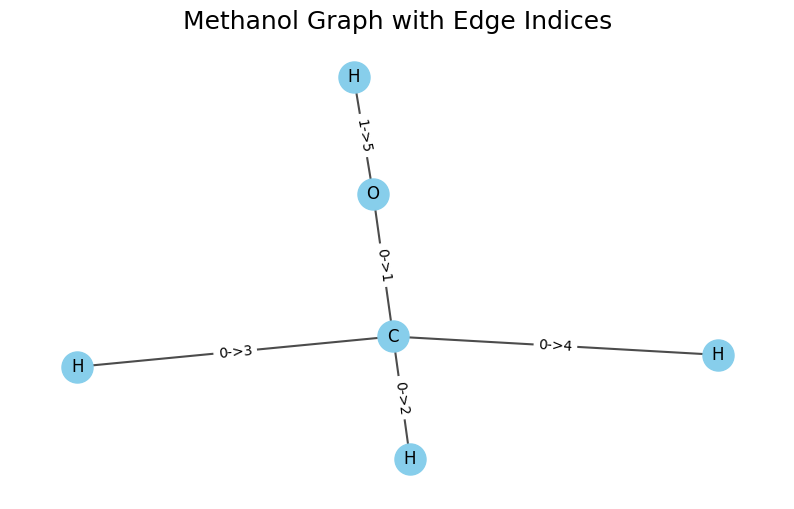


COO (Coordinate) Format Explanation:
In PyG, edge_index uses a sparse representation called COO format
- First row: source nodes (sender nodes)
- Second row: target nodes (receiver nodes)
- Each column represents one directed edge
For undirected graphs like molecules, each edge appears twice (in both directions)


In [ ]:
# Let's use a simpler molecule (Methanol) to understand the edge_index format
methanol_pyg = smiles_to_pyg(molecules["Methanol"])

print("Methanol as a PyG Data object:")
print(methanol_pyg)

# Extracting components
edge_index = methanol_pyg.edge_index.numpy()
x = methanol_pyg.x.numpy()

# Display the edge_index tensor
print("\nEdge Index Tensor:")
print(edge_index)

# Visualize what this means
methanol_mol = Chem.MolFromSmiles(molecules["Methanol"])
methanol_mol = Chem.AddHs(methanol_mol)
atom_symbols = [atom.GetSymbol() for atom in methanol_mol.GetAtoms()]

# Create visual representation of edges
plt.figure(figsize=(10, 6))
G = nx.Graph()

for i, symbol in enumerate(atom_symbols):
    G.add_node(i, label=symbol)

# Add edges from edge_index
for i in range(edge_index.shape[1]):
    source, target = edge_index[0, i], edge_index[1, i]
    # Only add each edge once (PyG has both directions)
    if source < target:
        G.add_edge(source, target)

pos = nx.spring_layout(G, seed=42)

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_labels(G, pos, labels={i: atom_symbols[i] for i in range(len(atom_symbols))}, font_size=12)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)

# Add edge indices
edge_labels = {}
for i in range(edge_index.shape[1]):
    source, target = edge_index[0, i], edge_index[1, i]
    if source < target:  # Only label one direction
        edge_labels[(source, target)] = f"{source}->{target}"

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Methanol Graph with Edge Indices")
plt.axis("off")
plt.show()

# Explain COO format
print("\nCOO (Coordinate) Format Explanation:")
print("In PyG, edge_index uses a sparse representation called COO format")
print("- First row: source nodes (sender nodes)")
print("- Second row: target nodes (receiver nodes)")
print("- Each column represents one directed edge")
print("For undirected graphs like molecules, each edge appears twice (in both directions)")

### ✅ Checkpoint Exercise: Working with PyG Data Objects

1. Convert the following SMILES string to a PyG Data object: "CC(=O)C" (acetone).
2. Examine the node features, edge_index, and edge_attr of your PyG Data object.
3. How many atoms and bonds does acetone have according to your representation?
4. Investigate the difference between `edge_index` and the adjacency matrix representation. Why might the COO format used in PyG be more efficient for large molecules?

## 6. Working with Molecular Datasets <a name="working-with-molecular-datasets"></a>

PyTorch Geometric provides easy access to various molecular datasets through its `MoleculeNet` class. These datasets are commonly used benchmarks for molecular property prediction.


Available MoleculeNet Datasets:
- ESOL
- FreeSolv
- Lipophilicity
- PCBA
- MUV
- HIV
- BACE
- BBBP
- Tox21
- ToxCast
- SIDER
- ClinTox

Loaded ESOL dataset with 1128 molecules
Node features: 9
Task type: Regression

Sample from ESOL dataset:
Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])

Available properties:
- edge_attr: torch.Size([68, 3])
- x: torch.Size([32, 9])
- edge_index: torch.Size([2, 68])
- smiles: OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 
- y: torch.Size([1, 1])


/home/scholz/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


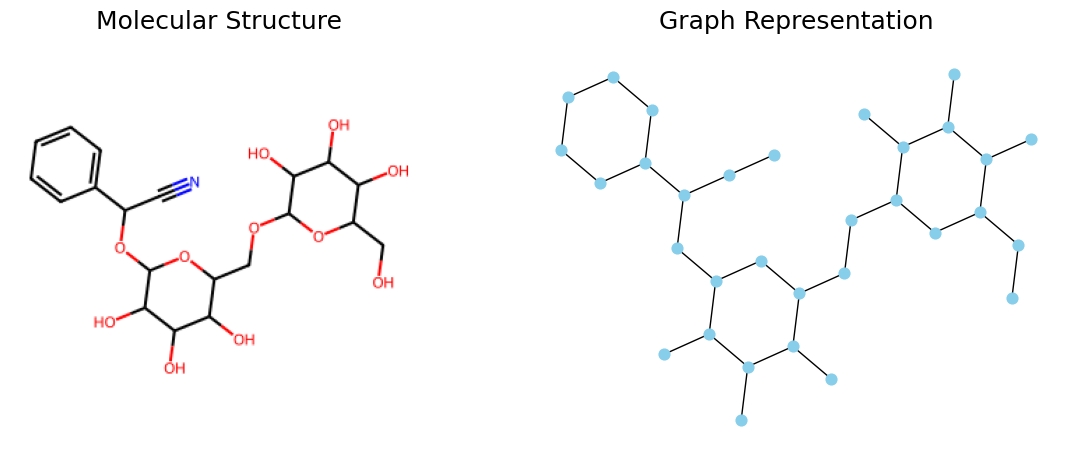


Target property (solubility): -0.7700


In [37]:
# List available datasets in MoleculeNet
# These datasets are commonly used benchmarks for molecular property prediction tasks
available_datasets = [
    "ESOL", "FreeSolv", "Lipophilicity", "PCBA", "MUV", "HIV",
    "BACE", "BBBP", "Tox21", "ToxCast", "SIDER", "ClinTox"
]

# Display all available datasets for reference
print("Available MoleculeNet Datasets:")
for dataset in available_datasets:
    print(f"- {dataset}")

# Load the ESOL dataset which contains water solubility data
# ESOL is a regression dataset predicting water solubility of molecules
esol_dataset = MoleculeNet(root='./data', name='ESOL')

# Print basic dataset information
print(f"\nLoaded ESOL dataset with {len(esol_dataset)} molecules")
print(f"Node features: {esol_dataset.num_features}")
print(f"Task type: {'Classification' if esol_dataset.num_classes < 100 else 'Regression'}")

# Get the first molecule from the dataset as a sample
sample = esol_dataset[0]
print("\nSample from ESOL dataset:")
print(sample)

# Print all available properties/attributes for the sample molecule
print("\nAvailable properties:")
for key in sample.keys():
    print(f"- {key}: {getattr(sample, key).shape if hasattr(getattr(sample, key), 'shape') else getattr(sample, key)}")

# Convert SMILES to RDKit molecule and create visualization
sample_mol = Chem.MolFromSmiles(sample.smiles)
sample_img = Draw.MolToImage(sample_mol, size=(300, 300))
# Generate 2D coordinates for the molecule
AllChem.Compute2DCoords(sample_mol)

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Show the molecular structure using RDKit's visualization
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.axis('off')
plt.title('Molecular Structure')

# Right subplot: Show the graph representation
plt.subplot(1, 2, 2)
# Convert PyG data to NetworkX graph
G = to_networkx(sample, to_undirected=True)
# Get the 2D coordinates from RDKit for consistent layout
pos = {}
for i, atom in enumerate(sample_mol.GetAtoms()):
    pos[i] = sample_mol.GetConformer().GetAtomPosition(i)
    pos[i] = (pos[i].x, pos[i].y)
# Draw the graph using the RDKit coordinates
nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=60)
plt.title('Graph Representation')

plt.tight_layout()
plt.show()

# Display the target property (water solubility) for the sample molecule
print(f"\nTarget property (solubility): {sample.y.item():.4f}")

### ✅ Checkpoint Exercise: Exploring MoleculeNet Datasets

1. Load a different dataset from MoleculeNet (e.g., "BBBP" - blood-brain barrier penetration).
2. Examine the first few samples. What is the prediction task for this dataset?
3. Compare the molecule sizes (number of atoms and bonds) across 5 random samples.
4. Retrieve and analyze the graph representation of the largest molecule in your sample. Why might larger molecules present challenges for graph neural networks?

## 7. Visualizing Molecular Graphs <a name="visualizing-molecular-graphs"></a>

Visualization is crucial for understanding and interpreting molecular graphs. Let's explore different visualization techniques:

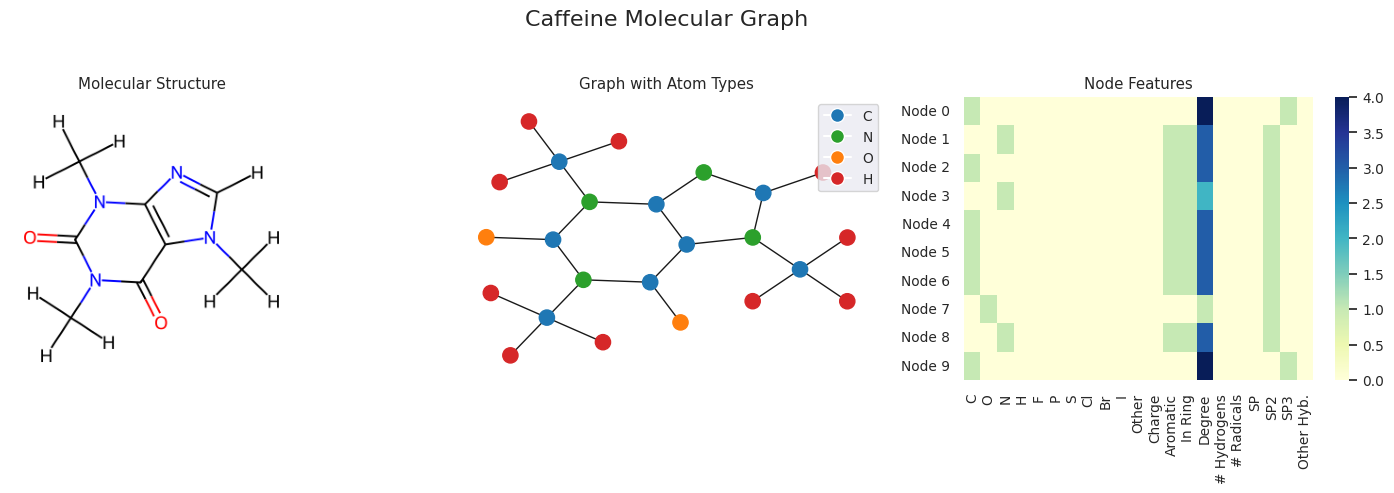

In [40]:
# Convert SMILES strings to PyG graph representations
pyg_molecules = {name: smiles_to_pyg(smiles) for name, smiles in molecules.items()}

def visualize_molecular_graph_with_features(data: Data, mol=None, title="Molecular Graph"):
    """
    Visualize a molecular graph with node features highlighted.

    Args:
        data: PyG Data object
        mol: RDKit molecule (optional)
        title: Plot title
    """
    # Create molecule from SMILES if not provided
    if mol is None and hasattr(data, 'smiles'):
        mol = Chem.MolFromSmiles(data.smiles)
        # Add hydrogens to explicit representation
        mol = Chem.AddHs(mol)

    # Create figure with three subplots
    plt.figure(figsize=(15, 5))

    # 1. RDKit molecular structure visualization
    if mol is not None:
        plt.subplot(1, 3, 1)
        # Add hydrogens to explicit representation
        mol = Chem.AddHs(mol)
        img = Draw.MolToImage(mol, size=(300, 300))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Molecular Structure')

    # 2. NetworkX graph visualization with atom type coloring
    plt.subplot(1, 3, 2)

    # Convert PyG data to NetworkX graph
    G = to_networkx(data, to_undirected=True)

    # Compute 2D coordinates for consistent layout
    AllChem.Compute2DCoords(mol)
    # Get the 2D coordinates from RDKit
    pos = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos[i] = mol.GetConformer().GetAtomPosition(i)
        pos[i] = (pos[i].x, pos[i].y)

    # Set up color scheme for different atom types
    node_colors = []
    legend_elements = []
    atom_types = ['C', 'O', 'N', 'H', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'Other']
    colors = plt.cm.tab10(np.linspace(0, 1, len(atom_types)))

    # Color nodes based on their atom type
    for node_idx, node_data in G.nodes(data=True):
        # Get the node features
        node_features = data.x[node_idx].numpy()
        # Determine the atom type (assumes one-hot encoding in first features)
        atom_type_idx = np.argmax(node_features[:len(atom_types)])
        if atom_type_idx < len(atom_types):
            node_colors.append(colors[atom_type_idx])
            # Add to legend if not already added
            if atom_types[atom_type_idx] not in [e.get_label() for e in legend_elements]:
                legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                                 markerfacecolor=colors[atom_type_idx],
                                                 markersize=10, label=atom_types[atom_type_idx]))

    # Draw graph with colored nodes
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=120)
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title('Graph with Atom Types')

    # 3. Feature heatmap visualization for node features
    plt.subplot(1, 3, 3)
    # Select up to 10 nodes to display features
    num_nodes_to_show = min(10, data.x.shape[0])
    sns.set(font_scale=0.9)
    # Define feature names for better visualization
    feature_names = ['C', 'O', 'N', 'H', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'Other',
                     'Charge', 'Aromatic', 'In Ring', 'Degree', '# Hydrogens', '# Radicals',
                     'SP', 'SP2', 'SP3', 'Other Hyb.']

    # Create heatmap of node features
    node_features = data.x[:num_nodes_to_show, :len(feature_names)].numpy()
    sns.heatmap(node_features, cmap='YlGnBu',
                xticklabels=feature_names,
                yticklabels=[f"Node {i}" for i in range(num_nodes_to_show)])
    plt.title('Node Features')
    plt.tight_layout()

    # Add overall title and adjust layout
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Visualize caffeine molecule as an example
caffeine_data = pyg_molecules["Caffeine"]
caffeine_mol = Chem.MolFromSmiles(molecules["Caffeine"])
visualize_molecular_graph_with_features(caffeine_data, caffeine_mol, "Caffeine Molecular Graph")

### Visualizing Different Molecular Features

Let's explore how various molecular features are represented in the graph:

/tmp/ipykernel_3591169/3504985768.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nodes = nx.draw_networkx_nodes(G, pos, node_color=node_values, cmap=plt.cm.get_cmap(cmap),


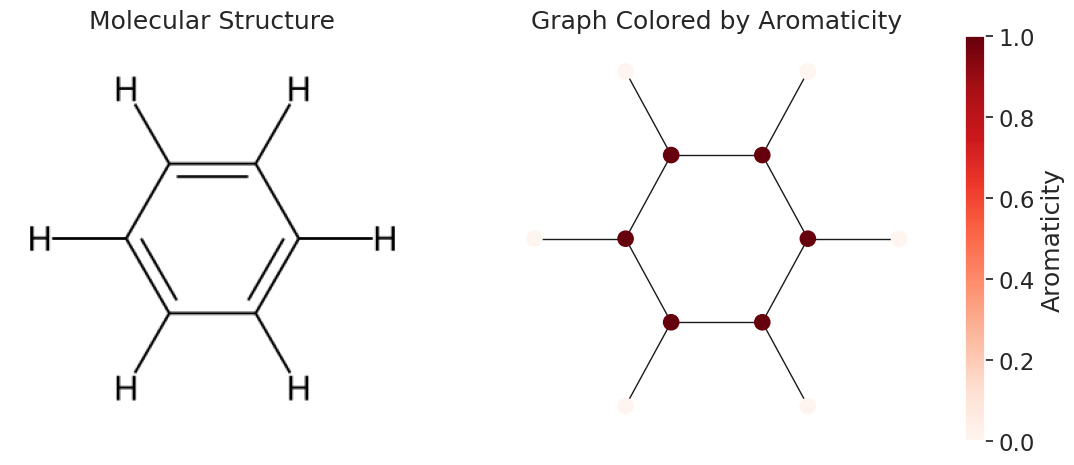

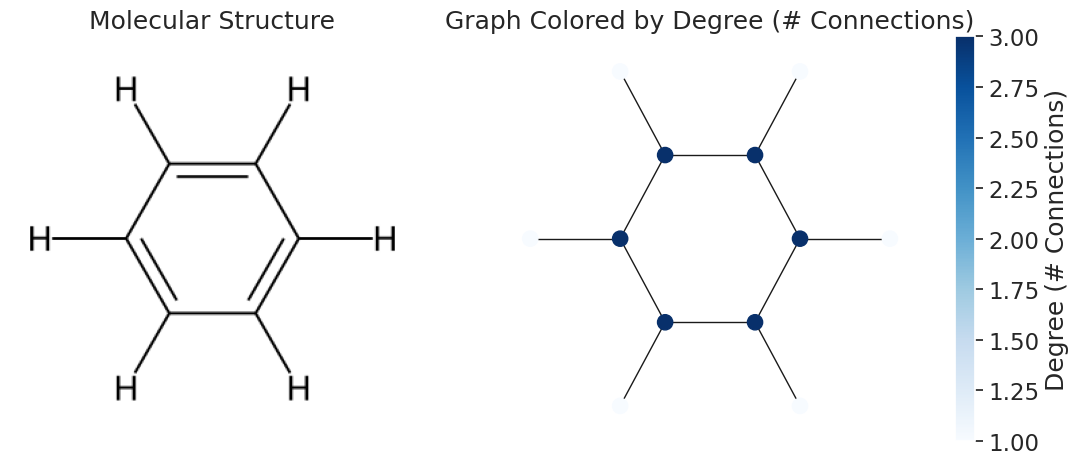

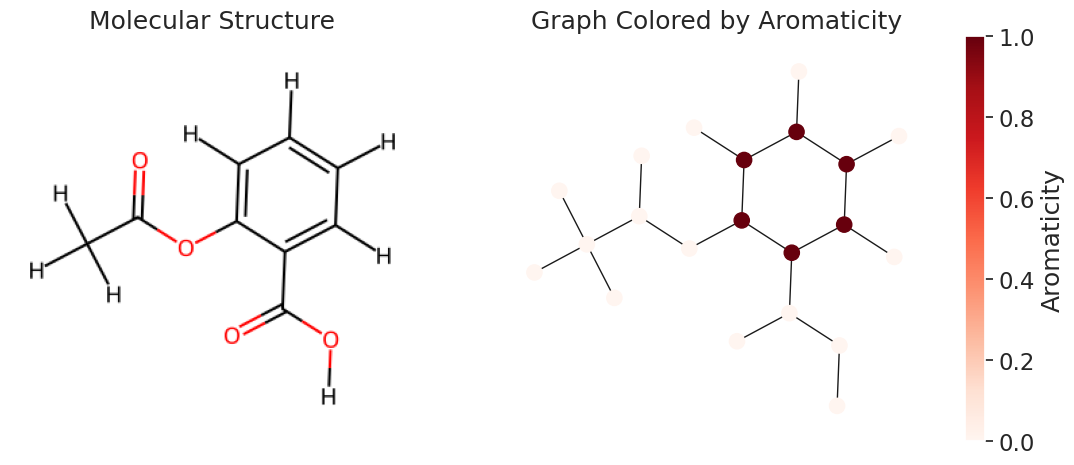

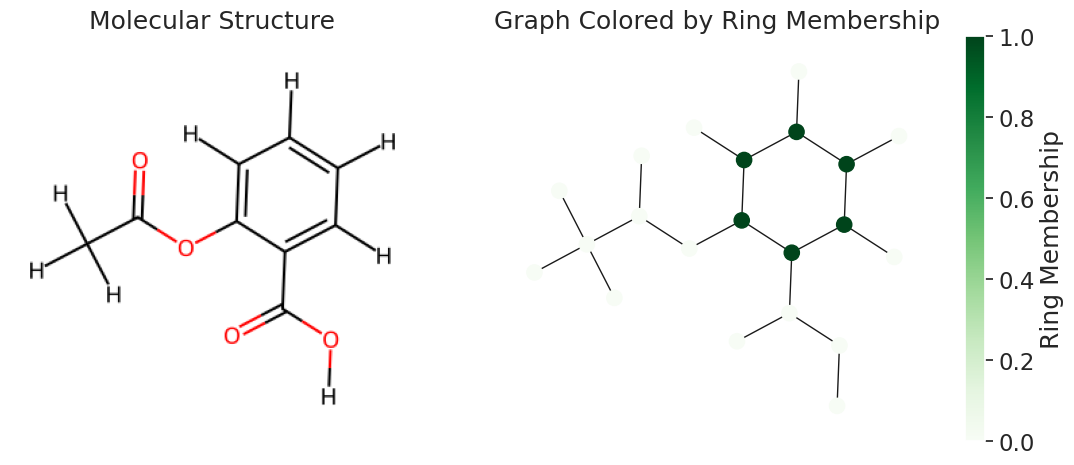

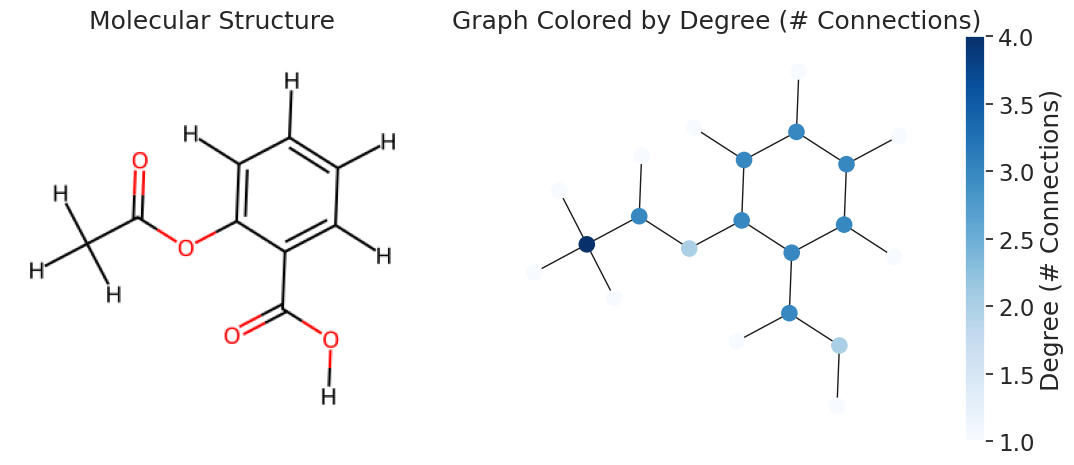

In [41]:
def visualize_graph_property(data: Data, mol, property_idx: int, property_name: str, cmap='viridis'):
    """
    Visualize a specific molecular graph property.

    Args:
        data: PyG Data object
        mol: RDKit molecule
        property_idx: Index of the property in the feature vector
        property_name: Name of the property for display
        cmap: Colormap to use
    """
    sns.set(font_scale=1.5)
    plt.figure(figsize=(12, 5))

    # 1. RDKit molecular structure
    # Add hydrogens to explicit representation
    mol = Chem.AddHs(mol)
    plt.subplot(1, 2, 1)
    img = Draw.MolToImage(mol, size=(300, 300))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Molecular Structure')

    # 2. Graph colored by property
    plt.subplot(1, 2, 2)
    G = to_networkx(data, to_undirected=True)

    AllChem.Compute2DCoords(mol)

    G = to_networkx(data, to_undirected=True)
    # Get the 2D coordinates from RDKit
    pos = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos[i] = mol.GetConformer().GetAtomPosition(i)
        pos[i] = (pos[i].x, pos[i].y)

    # Get property values for each node
    node_values = [data.x[node_idx, property_idx].item() for node_idx in G.nodes()]

    # Draw the graph with nodes colored by property
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_values, cmap=plt.cm.get_cmap(cmap),
                                  node_size=120, vmin=min(node_values), vmax=max(node_values))
    nx.draw_networkx_edges(G, pos)

    # Add colorbar
    plt.colorbar(nodes, label=property_name)
    plt.title(f'Graph Colored by {property_name}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Let's visualize different properties for benzene
benzene_data = pyg_molecules["Benzene"]
benzene_mol = Chem.MolFromSmiles(molecules["Benzene"])

# Visualize aromaticity
visualize_graph_property(benzene_data, benzene_mol, 12, "Aromaticity", cmap='Reds')

# Visualize node degree (number of connections)
visualize_graph_property(benzene_data, benzene_mol, 14, "Degree (# Connections)", cmap='Blues')

# Compare with aspirin for more variety
aspirin_data = pyg_molecules["Aspirin"]
aspirin_mol = Chem.MolFromSmiles(molecules["Aspirin"])

# Visualize aromaticity in aspirin
visualize_graph_property(aspirin_data, aspirin_mol, 12, "Aromaticity", cmap='Reds')

# Visualize ring membership in aspirin
visualize_graph_property(aspirin_data, aspirin_mol, 13, "Ring Membership", cmap='Greens')

# Visualize node degree (number of connections) in aspirin
visualize_graph_property(aspirin_data, aspirin_mol, 14, "Degree (# Connections)", cmap='Blues')

### ✅ Checkpoint Exercise: Advanced Visualization

1. Choose one of the molecules we've worked with (or a new one of your choice) and create three different visualizations that highlight:
   - The hybridization state of each atom
   - The formal charge distribution
   - The number of hydrogen atoms attached to each heavy atom

2. Challenge: Create a visualization that simultaneously shows two different properties using both node color and node size. For example, use color for atom type and size for degree.

3. Compare how aromatic and non-aromatic rings appear in graph representations. Choose a molecule that contains both (hint: try naphthalene - "c1ccc2ccccc2c1") and highlight the differences visually.

## 8. Conclusion <a name="conclusion"></a>

Key takeaways from this tutorial include:

1. **Molecules as Graphs**: Molecules can be naturally represented as graphs where atoms are nodes and chemical bonds are edges, allowing machine learning models to work directly with molecular structures rather than requiring hand-engineered descriptors.

2. **Feature Engineering**: Rich chemical information can be encoded in node features (atom properties like element type, hybridization, aromaticity) and edge features (bond properties like bond type, conjugation), providing models with important context about molecular behavior.

3. **PyTorch Geometric Implementation**: Specialized libraries like PyTorch Geometric provide efficient data structures for molecular graphs, using sparse representations (COO format) and tensor formats that enable GPU acceleration for graph neural networks.

4. **MoleculeNet Datasets**: Resources like MoleculeNet provide standardized datasets for molecular property prediction tasks, facilitating model development and benchmarking for applications ranging from solubility to toxicity prediction.

5. **Visualization Techniques**: Visualizing molecular graphs with highlighted features helps interpret how different molecular properties (aromaticity, ring membership, connectivity) are distributed through the structure, enabling better understanding of structure-property relationships.

### Additional Resources for Further Learning

1. "A Gentle Introduction to Graph Neural Networks" on [Distill.pub](https://distill.pub/2021/gnn-intro/): An interactive, visual introduction to graph neural networks with examples related to molecular representation.

2. [PyTorch Geometric Tutorials](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html): Official tutorials for the PyG library with excellent examples of molecular graph neural networks.

